# <center>  Проект: классификация (банковский сектор)

## Постановка задачи

*Бизнес-задача:* определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

*Техническая задача*: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Знакомство с данными

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [206]:
#загрузка данных
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [207]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

>Вывод: Пропуски есть в признаке balance , их 25

### Задание 2

In [175]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

>Вывод: В признаке job есть пропущенные значения в виде статуса 'unknown'

### Задание 3

In [176]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
if df['balance'].dtype != 'float64':
    df['balance'] = df['balance'].str.replace(r'[^\d,-]', '', regex=True)# через regex отбираем цифры, запятые и минус
    df['balance'] = df['balance'].str.replace(',', '.', regex=True).astype('float64') #заменяем запятую на точку, выставляем тип float64
print(round(df['balance'].mean(),3))

1529.129


### Задание 4

In [177]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()
bal_mean = round(df['balance'].mean(),3)
print(f'Среднеарифметическое по признаку balance: {bal_mean} ')

Среднеарифметическое по признаку balance: 1526.936 


### Задание 5

In [178]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df.loc[(df['job'] == 'unknown'),'job']=df['job'].mode()[0]
df.loc[(df['education'] == 'unknown'),'education']=df['education'].mode()[0]
print(round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(),3))

1598.883


### Задание 6

In [179]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr_mod(data, feature,left=1.5,right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    
    iqr = quartile_3 - quartile_1 
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod(df, 'balance')
print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей после отчистки: {cleaned.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей после отчистки: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

Сколько клиентов открыли депозит?: 4681


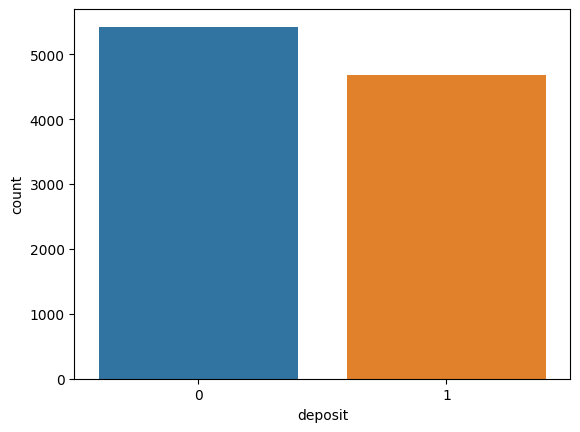

In [180]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
#перекодируем целевой признак где yes это 1, no это 0
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
sns.countplot(data=cleaned, x='deposit');
depo_yes_cnt = cleaned[cleaned['deposit'] == 1]['deposit'].count()
print(f'Сколько клиентов открыли депозит?: {depo_yes_cnt}')

>Вывод: в целевом признаке присутствует небольшой дисбаланс.

### Задания 2 и 3

In [181]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned.describe(include=['int64','float64']).round(3)

,age,balance,day,duration,campaign,pdays,previous,deposit
count,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000
mean,40.895,807.654,15.590,368.743,2.517,51.320,0.816,0.463
std,11.735,994.152,8.442,346.652,2.707,109.644,2.244,0.499
min,18.000,-2049.000,1.000,2.000,1.000,-1.000,0.000,0.000
25%,32.000,95.000,8.000,137.000,1.000,-1.000,0.000,0.000
50%,38.000,445.000,15.000,252.000,2.000,-1.000,0.000,0.000
75%,48.000,1227.000,22.000,490.000,3.000,2.000,1.000,1.000
max,95.000,4063.000,31.000,3881.000,43.000,854.000,58.000,1.000


> Вывод по количественным переменным: Судя по стандартному отклонению - в данных есть выбросы.


### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


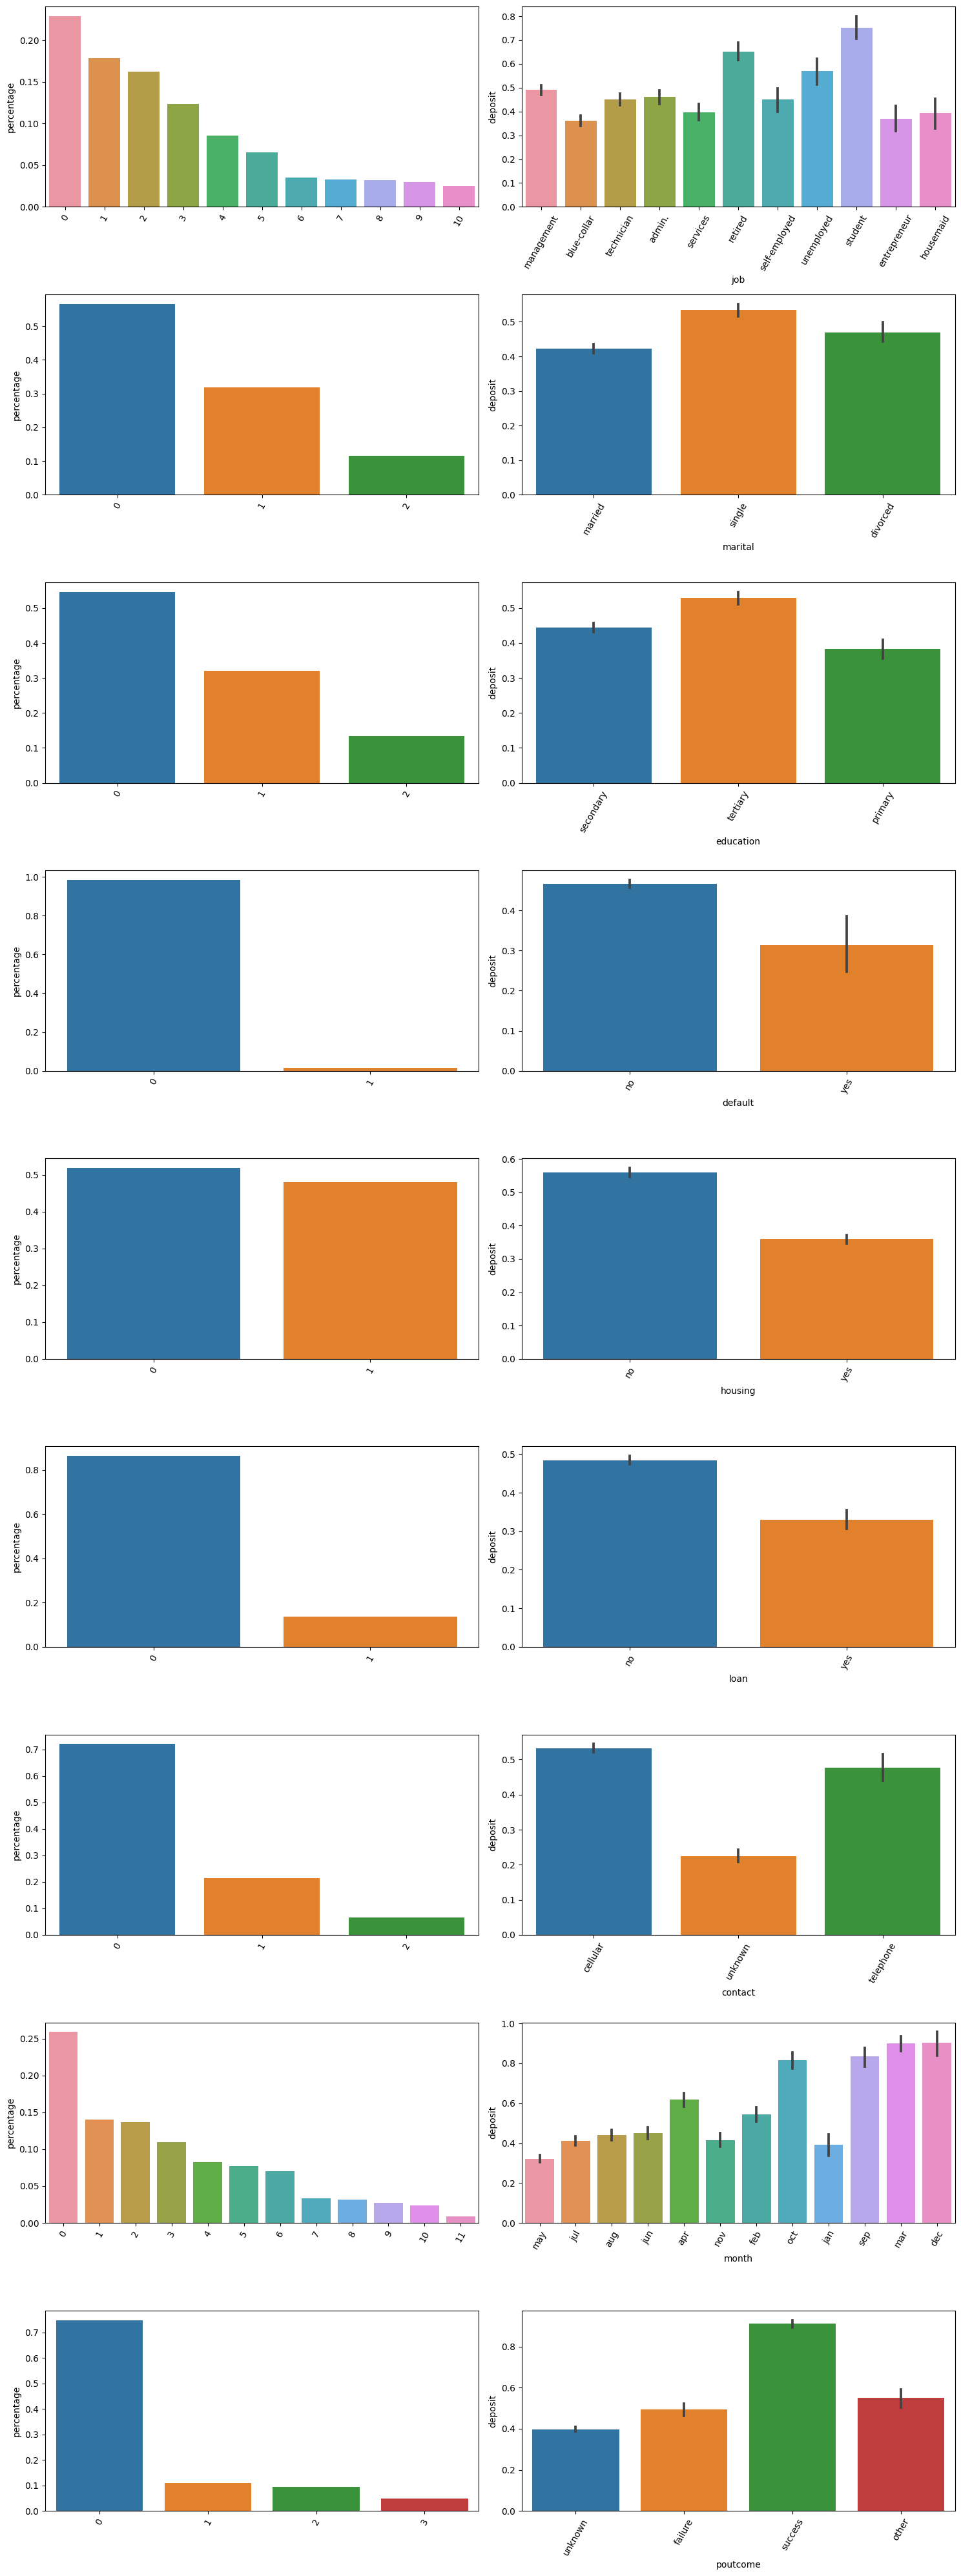

In [182]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
#общая статистическая информация по категориальным признакам
display(cleaned.describe(include='object'))
#cоставляем список категориальных признаков
types = cleaned.dtypes
cat_features = list(types[(types == 'object')].index)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=count_data.index, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей с депозитом в зависимости от категории
    mean_barplot = sns.barplot(data=cleaned, x=feature, y='deposit', ax=axes[i][1], order=count_data[feature])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

> Выводы по категориальным признакам:
 - данные по принаку job: можно отметить, что >20% - это люди с профессией Management. Депозиты есть у большинства - retired(пенсионеров), unemploymend(безработных) и student(студентов) - что вполне логично, так как они имеют внешний источник дохода, через которые получают средства от ПФР, родителей и пособия по безработице. 
 - данные по признаку marital: >50% клиентов - это married(женатые/замужние) люди, при этом только 40% из них имеют депозит. >50% - single(одиноких) имеют депозит. ±45% divorced(разведенных) имеют депозит.
 - данные по признаку education: >50% клиетов - это люди со средним образованием, при этом 45% из них имеют депозит. 30% - клиенты с высшим образование, при этом большинство из них (>50%) имеют депозит. 15% клиентов - с начальным образование, <40% имеют депозит.
 - данные по признаку default(просроченные кредит): 99% клиентов - не имеют просроченого кредита, депозит из них есть у 45%. Среди клиентов с просроченным кредитом - 30% имеют депозит.
 - данные по признаку housing(ипотека): 52% клиентов - есть ипотека,35% из них имеют депозит. Среди клиентов которых нет ипотеки - >55% имеют депозит.
 - данные по признаку loan(кредит наличными): >83% клиентов - не имеют кредита наличными, депозит есть у 50% из них. Среди клиентов у которых есть кредит наличными - >35% имеют депозит.
 - данные по признаку contact(тип контакта с клиентом): >70% клиентов - тип контакта через мобильный телефон, >50% есть депозит. У 20% клиентов - контакт не известен(Unknown), при этом 22% из них имеют депозит в банке. <10% клиентов - контактируют через стационарный телефон/
 - данные по признаку month(месяц, в котором был последний контакт): >67% клиентов имели контакт в мае,июне,июле,августе, ±40% из них имеют депозит. Это показывает, что у последнего контакта есть сезонность - люди охотнее контактируют в летние месяцы, когда наступает основной период отпусков. Менее 33% клиентов контактирует в осенью, зимой и весной - это основные рабочие месяцы.
 - данные по признаку poutcome(результат прошлой маркетинговой кампании): >80% клиентов - результат unknown и faikure, ±40% из них имеют депозит. 10% клиентов - результат Success, >80% из них имеют депозит. 5% - статус Other, приэтом депозит есть у >45% из них.  С одной стороны присутствует большая неопределенность по результам кампании(>80% статус неизвестен), c другой в 10% кампания показала высокую эффективность (>80%).


### Задание 6

In [183]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
for each in cleaned['poutcome'].value_counts().index:
    #выделяем статус, где соотношения успех\неудача больше 2
    if (cleaned[(cleaned['deposit'] == 1) & (cleaned['poutcome'] == each)]['deposit'].count() / cleaned[(cleaned['deposit'] == 0) & (cleaned['poutcome'] == each)]['deposit'].count()) > 2:
        print(f'Значение статуса: {each}')

Значение статуса: success


### Задание 7

In [184]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
cleaned[cleaned['deposit'] == 0]['month'].mode()[0]

'may'

### Задание 8

In [185]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_group(arg):
    """ Функция возвращает имя категория для возраста

    Args:
        arg (int64): возраст

    Returns:
        str: наименование возрастной категории
    """
    if (arg < 30):
        return '<30'
    elif (arg >= 30) & (arg < 40):
        return '30-40'
    elif (arg >= 40) & (arg < 50):
        return '40-50'
    elif (arg >= 50) & (arg < 60):
        return '50-60'
    elif (arg >= 60):
        return '60+'
    else: 
        return 'unknown'

cleaned['age_group'] = cleaned['age'].apply(get_age_group)

for each in cleaned['age_group'].value_counts().index:
    #выделяем статус, где соотношение есть депозит больше, чем нет
    if cleaned[(cleaned['deposit'] == 1) & (cleaned['age_group'] == each)]['deposit'].count() > cleaned[(cleaned['deposit'] == 0) & (cleaned['age_group'] == each)]['deposit'].count():
        print(f'Значение возрастной группы: {each}')

Значение возрастной группы: <30
Значение возрастной группы: 60+


### Задания 9 и 10

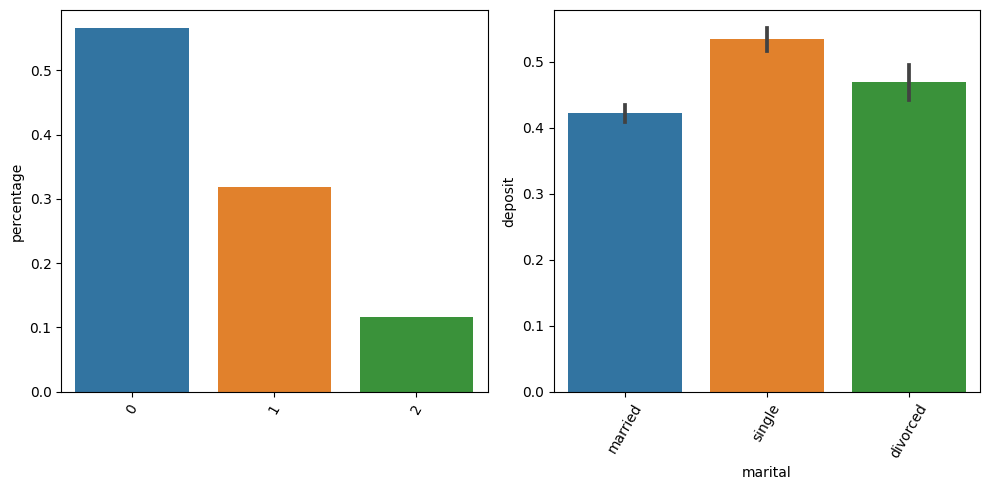

In [186]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#Строим количественную столбчатую для долевого соотношения категориb marital
count_data = (cleaned['marital'].value_counts(normalize=True)
                .sort_values(ascending=False)
                .rename('percentage')
                .reset_index())
count_barplot = sns.barplot(data=count_data, x=count_data.index, y='percentage', ax=axes[0])
count_barplot.xaxis.set_tick_params(rotation=60)
#Строим столбчатую диаграмму доли людей с депозитом в зависимости от marital
mean_barplot = sns.barplot(data=cleaned, x='marital', y='deposit', ax=axes[1], order=count_data['marital'])
mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

>Вывод: 
- данные по признаку marital: >50% клиентов - это married(женатые/замужние) люди, при этом только 40% из них имеют депозит. >50% - single(одиноких) имеют депозит. ±45% divorced(разведенных) имеют депозит.

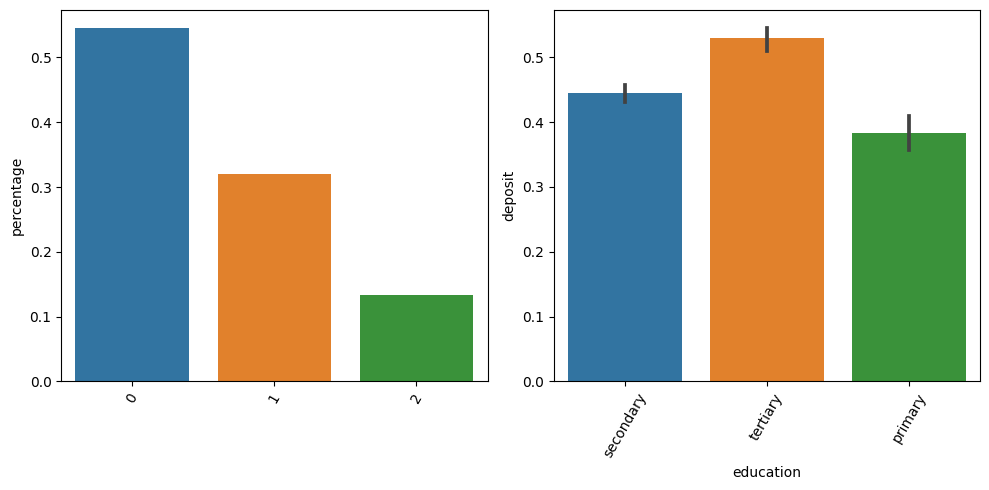

In [187]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#Строим количественную столбчатую для долевого соотношения категориb marital
count_data = (cleaned['education'].value_counts(normalize=True)
                .sort_values(ascending=False)
                .rename('percentage')
                .reset_index())
count_barplot = sns.barplot(data=count_data, x=count_data.index, y='percentage', ax=axes[0])
count_barplot.xaxis.set_tick_params(rotation=60)
#Строим столбчатую диаграмму доли людей с депозитом в зависимости от marital
mean_barplot = sns.barplot(data=cleaned, x='education', y='deposit', ax=axes[1], order=count_data['education'])
mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

>Вывод:
- данные по признаку education: >50% клиетов - это люди со средним образованием, при этом 45% из них имеют депозит. 30% - клиенты с высшим образование, при этом большинство из них (>50%) имеют депозит. 15% клиентов - с начальным образование, <40% имеют депозит.

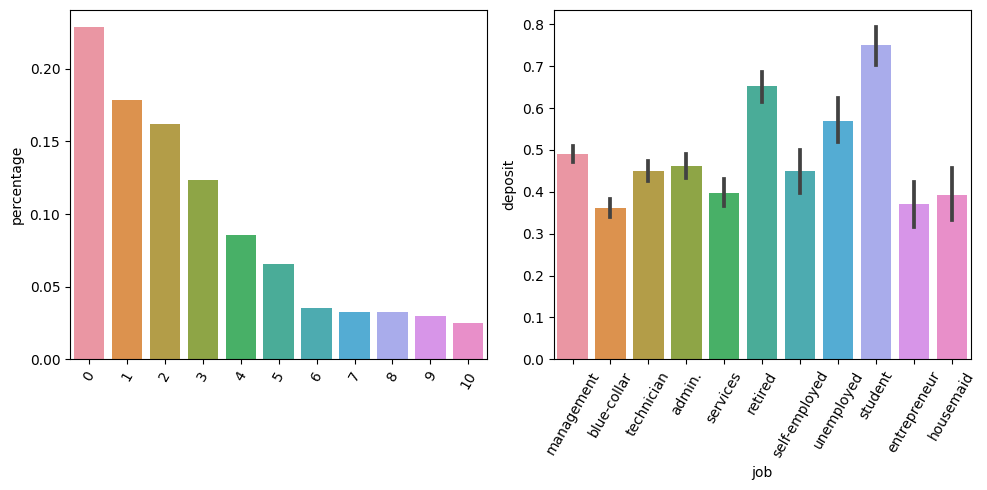

In [188]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#Строим количественную столбчатую для долевого соотношения категориb job
count_data = (cleaned['job'].value_counts(normalize=True)
                .sort_values(ascending=False)
                .rename('percentage')
                .reset_index())
count_barplot = sns.barplot(data=count_data, x=count_data.index, y='percentage', ax=axes[0])
count_barplot.xaxis.set_tick_params(rotation=60)
#Строим столбчатую диаграмму доли людей с депозитом в зависимости от job
mean_barplot = sns.barplot(data=cleaned, x='job', y='deposit', ax=axes[1], order=count_data['job'] )
mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 11

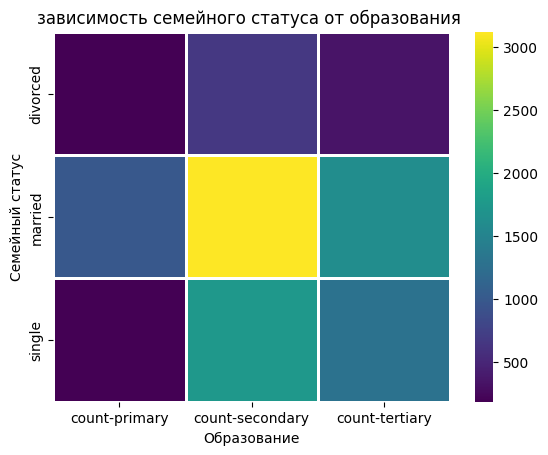

In [189]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
edu_mar = cleaned.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc=['count'],
    fill_value=0
)

#fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
heatmap = sns.heatmap(
    edu_mar,
    linewidth=1,
    linecolor='w',
    cmap='viridis'
)
heatmap.set_title('зависимость семейного статуса от образования ');
heatmap.set_xlabel('Образование');
heatmap.set_ylabel('Семейный статус');

>Вывод: Среди клиентов с депозитом больше всего женатых\замужних клиентов со средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [190]:
# преобразуйте уровни образования
LE=LabelEncoder()
cleaned['education'] = LE.fit_transform(cleaned['education'])
#преобразуем age_group
cleaned['age_group'] = LE.fit_transform(cleaned['age_group']) 
#сумма значений education
cleaned['education'].sum()

11995

### Задания 2 и 3

In [191]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)

sum_mean = cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()
#сумма средних по перобразованным бинарным признакам
sum_mean.round(3)

0.635

### Задание 4

In [192]:
# создайте дамми-переменные
dummies_data = pd.get_dummies(cleaned, drop_first=True, dtype='int')
dummies_data.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,0,1,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,0,1,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,0,1,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,0,1,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,0,1,0,0,0,0,0,1


### Задания 5 и 6

<AxesSubplot:>

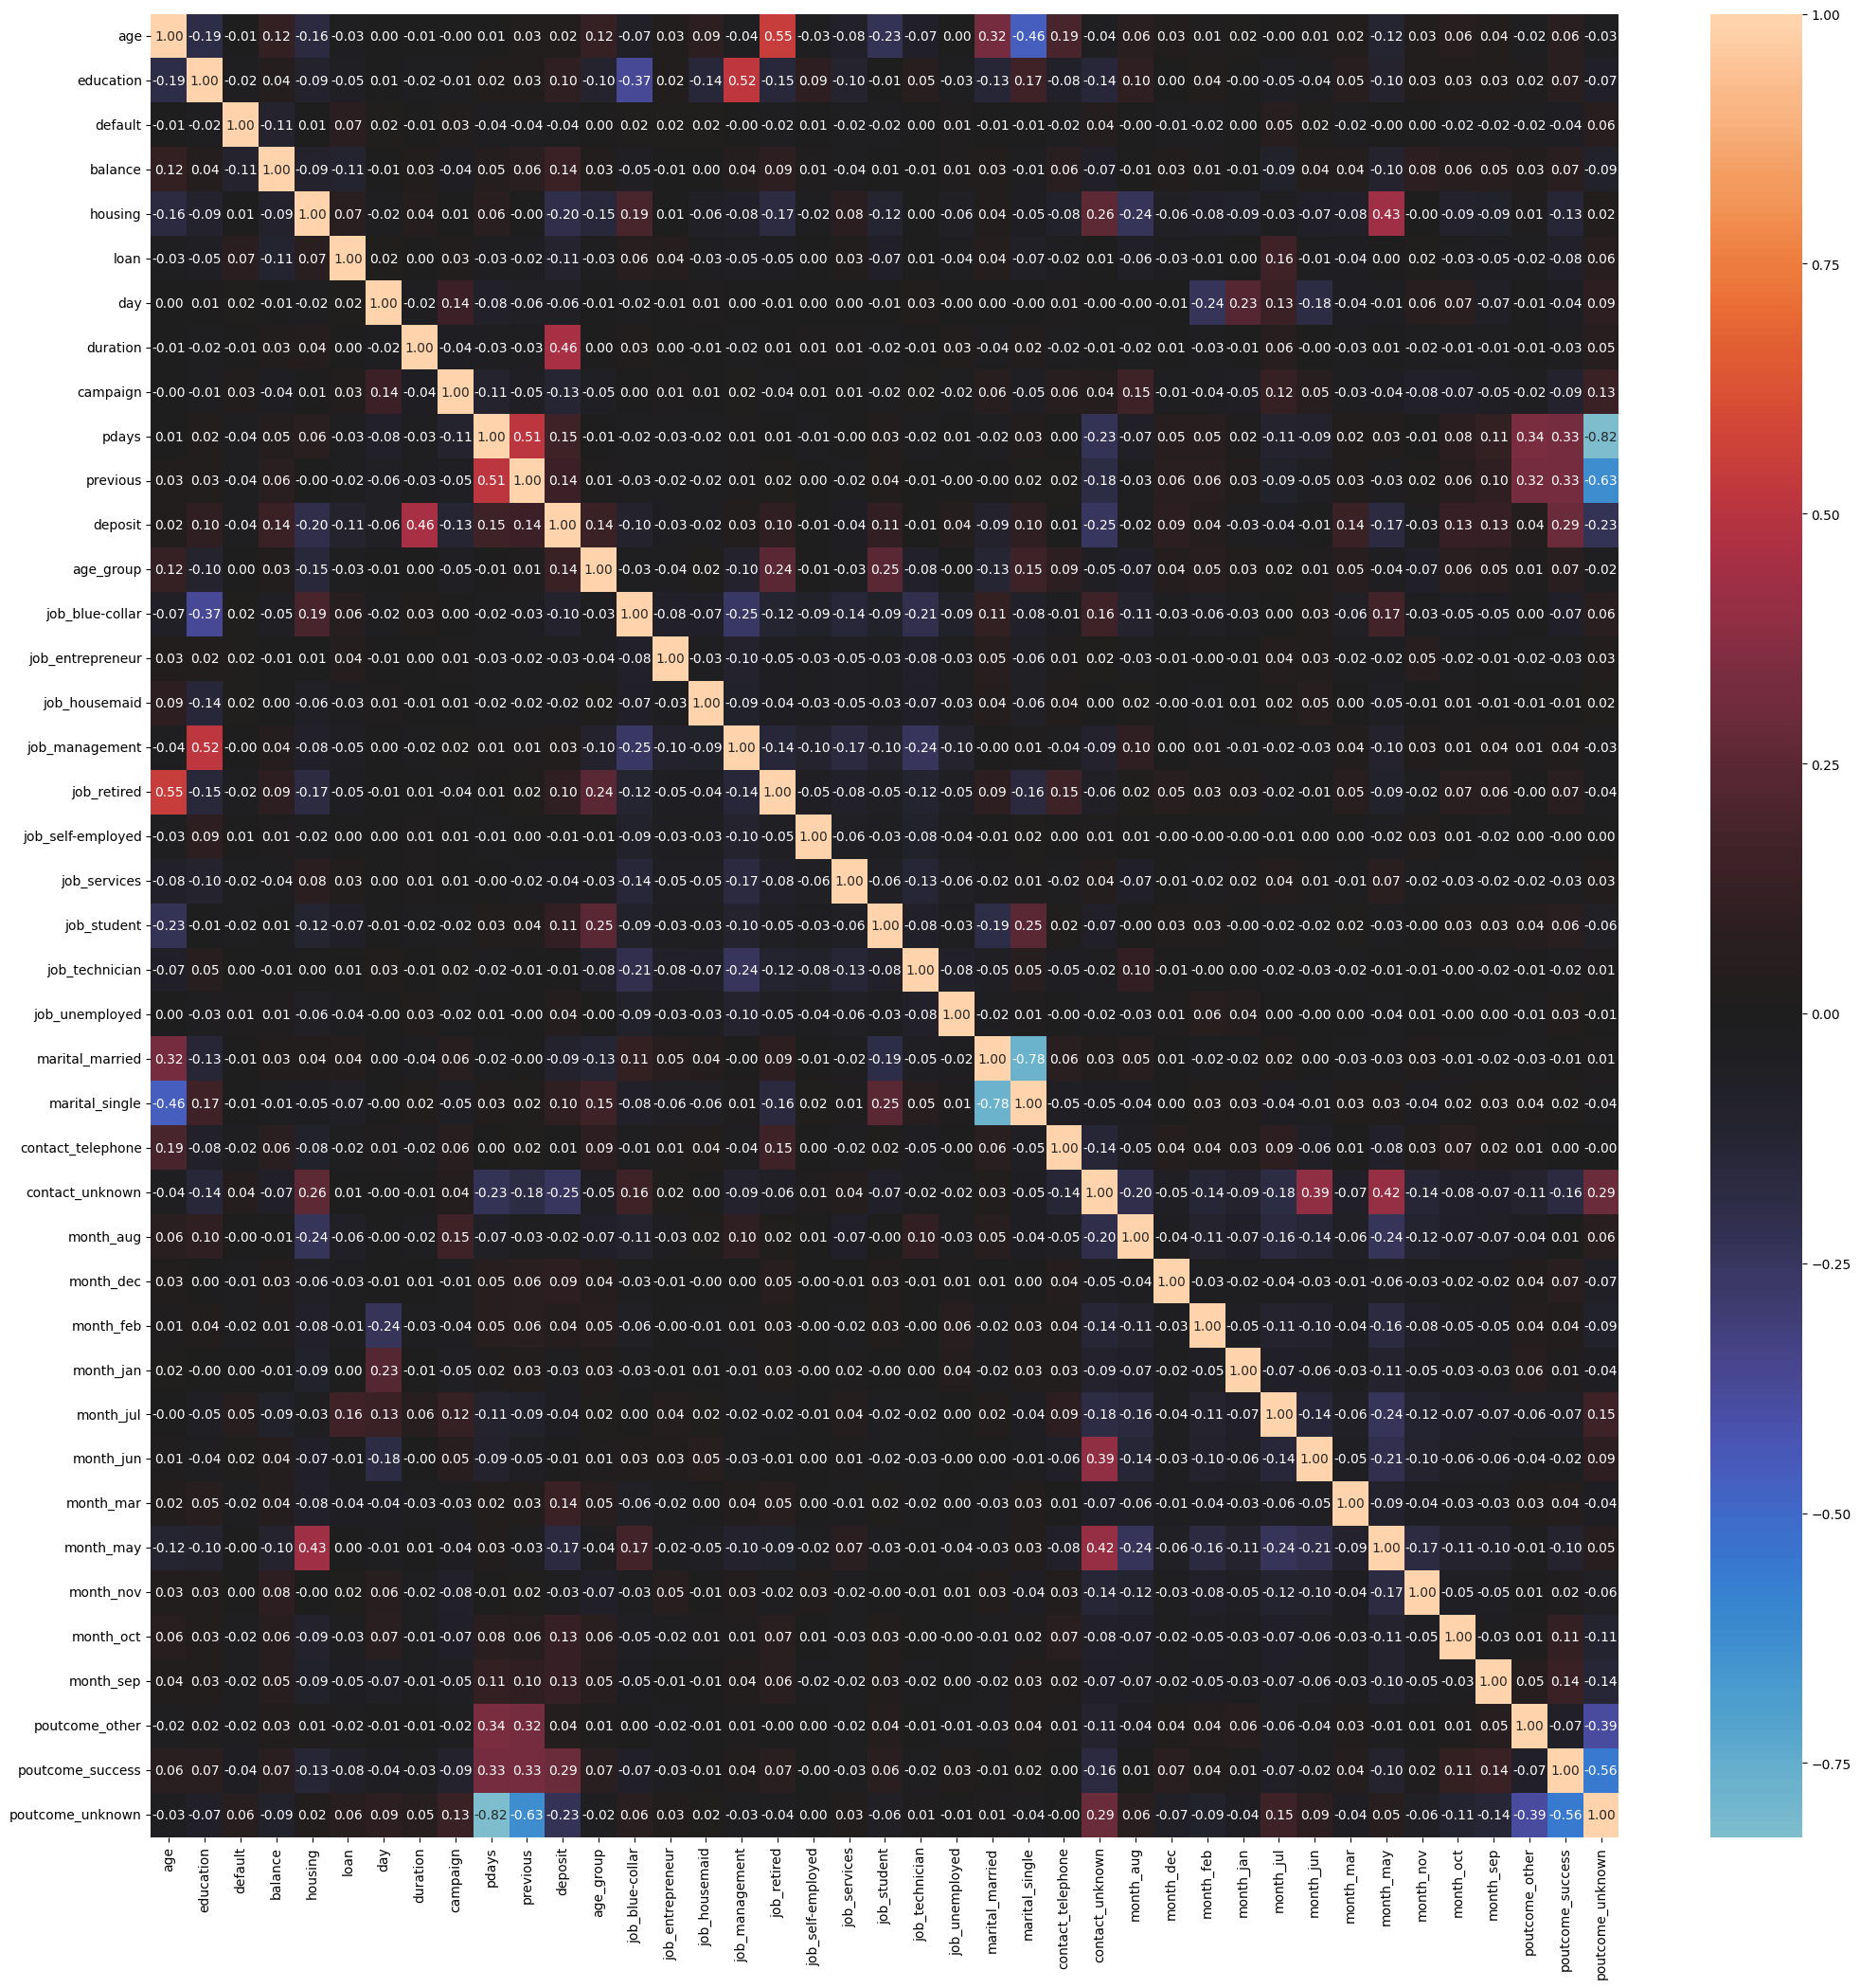

In [193]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(25,25))  
sns.heatmap(dummies_data.corr(),fmt='.2f',annot=True, center=0)

>Вывод: По матрице корреляции мы видим, что для целевого признака (deposit) наибольшую степень корреляции показывают признаки: Duration, Poutcome_success, Contact_celluar. Мультиколлериарности в признаках нет (корреляция менее 0.9)

### Задания 7 и 8

In [194]:
X = dummies_data.drop(['deposit'], axis=1)
y = dummies_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки {X_test.shape}')
print(f'Cреднее значение целевой переменной на тестовой выборке {y_test.mean().round(2)}')

Размер тестовой выборки (3335, 40)
Cреднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [195]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(k=15)
selector.fit(X_train, y_train)

kbest15 = selector.get_feature_names_out()
# оставляем в тренировочной и тестовой выборках только 15 наиболее подходящих признаков 
X_train = X_train[kbest15]
X_test = X_test[kbest15]

print(f'15 наиболее подходящих признаков:\n  {kbest15}')

15 наиболее подходящих признаков:
  ['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'age_group' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [196]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#строим матрицу
X_test_scaled_matrix = pd.DataFrame(X_test_scaled)
#считаем среднее по первому столбцу
first_col_mean = X_test_scaled_matrix[0].mean().round(2)
print(f'Среднее по первому столбцу: {first_col_mean}')

Среднее по первому столбцу: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [197]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter = 1000)
#Обучаем модель
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.78


### Задания 2,3,4

In [198]:
# обучите решающие деревья, настройте максимальную глубину
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_test_pred = dt.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.81


### Задание 5

In [199]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,#5-fold cross validation
    n_jobs=-1#количество jobs запушеных параллельно
    
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))


CPU times: user 150 ms, sys: 103 ms, total: 253 ms
Wall time: 4.11 s
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [200]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(criterion = 'gini', n_estimators = 100, min_samples_leaf = 5, max_depth = 10, random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_test_pred = rf.predict(X_test_scaled)
print('Test accuracy_score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test recall_score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Test accuracy_score: 0.83
Test recall_score: 0.84


### Задания 2 и 3

In [201]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    min_samples_leaf = 5,
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_test_pred = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


### Задание 4

In [202]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', log_reg),
    ('dt', grid_search_tree),
    ('gb', gb)
     
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=log_reg
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Precision_score 
print(f'Precision_score для стекинга {round(metrics.precision_score(y_test, y_pred_stack), 2)}')

Precision_score для стекинга 0.81


### Задание 5

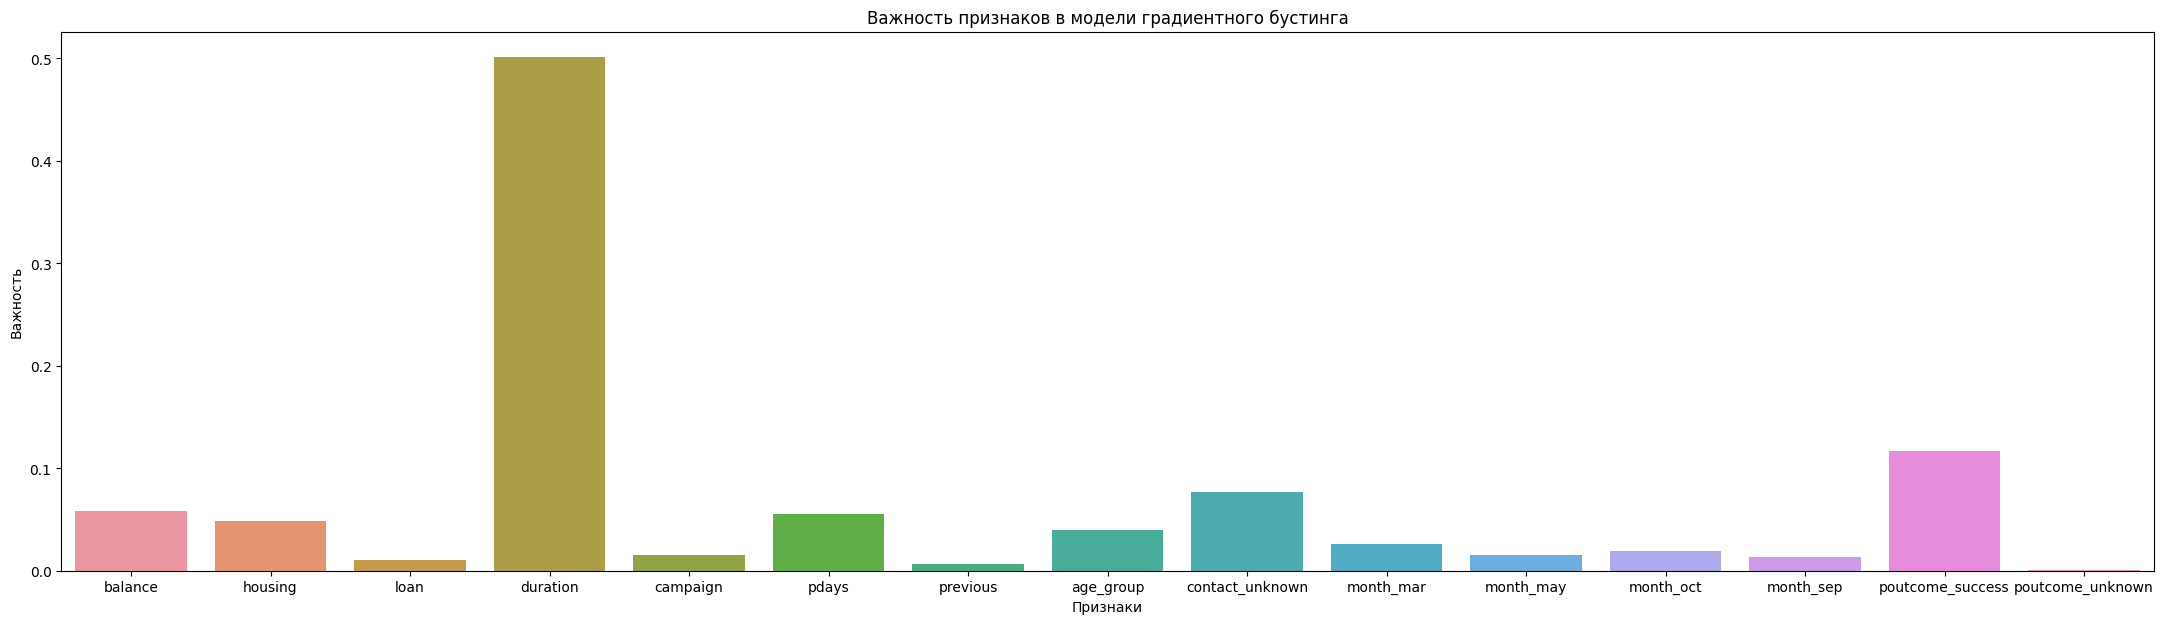

In [203]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(27, 7)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Важность признаков в модели градиентного бустинга')
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность');

>Вывод: самыми важными по убыванию являеются признаки Duration, Poutcome_success, Contact_unknown. 

>Вопрос: Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

>Ответ: 
 1. Продолжительный разговоров - показатель интереса клиента к предложению. 
 2. Удачный результат в прошлой рекламной компании увеличивает шанс на успех в новой.
 3. Важен факт наличия контакта с клиентом.  

### Задания 6,7,8

In [204]:
import optuna
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model_rf.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model_rf.predict(X_train_scaled)).round(2)

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
#визуализируем
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

[I 2024-08-11 11:36:56,337] A new study created in memory with name: RandomForestClassifier
[I 2024-08-11 11:36:57,065] Trial 0 finished with value: 0.89 and parameters: {'n_estimators': 133, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.89.
[I 2024-08-11 11:36:57,757] Trial 1 finished with value: 0.86 and parameters: {'n_estimators': 154, 'max_depth': 21, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.89.
[I 2024-08-11 11:36:58,386] Trial 2 finished with value: 0.92 and parameters: {'n_estimators': 108, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.92.
[I 2024-08-11 11:36:59,258] Trial 3 finished with value: 0.87 and parameters: {'n_estimators': 175, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.92.
[I 2024-08-11 11:37:00,036] Trial 4 finished with value: 0.86 and parameters: {'n_estimators': 171, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.92.
[I 2024-08-11 11:37:00,596] Trial

f1_score на тестовом наборе: 0.82
accuracy на тестовом наборе: 0.83




## Общий вывод по задаче:
 1. Удалось определить важные признаки повышающие результативность модели - это Duration, Poutcome_success, Contact_unknown. Влияя на них мы можем существенно улучшить результаты маркейтинговой компании.
 2. Удалось построить модель МО, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.